In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

#### Clase personalizada para redimensionar imágenes del dataset MNIST

In [38]:
class MNISTResized(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_resized = F.interpolate(img.unsqueeze(0), size=(7, 7), mode='bilinear', align_corners=False)
        img_resized = img_resized.squeeze(0)
        return img, img_resized, target

#### Transformación para normalizar los datos

In [28]:
transform = transforms.Compose( 
    [transforms.ToTensor(), 
     transforms.Normalize((0.5), (0.5)) 
    ])
transform = transforms.ToTensor() 

#### Carga de datos

In [29]:
mnist_train = MNISTResized(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=64, shuffle=True)

mnist_data_valid = MNISTResized(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid, batch_size=64, shuffle=True)

#### Definición de las clases Encoder, Decoder y Autoencoder

In [30]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.Tanh()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.Tanh()
        self.fc = nn.Linear(128 * 3 * 3, latent_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [31]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.feature_size = 64 * 3 * 3
        self.fc = nn.Linear(latent_size, self.feature_size)
        self.conv_trans1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # salida: [32, 7, 7]
        self.conv_trans2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # salida: [16, 14, 14]
        self.conv_trans3 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 3, 3)
        x = F.relu(self.conv_trans1(x))
        x = F.relu(self.conv_trans2(x))
        x = torch.sigmoid(self.conv_trans3(x))
        x = F.interpolate(x, size=(14, 14), mode='bilinear', align_corners=False)
        return x


In [32]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Configuración del modelo y entrenamiento

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_size = 40
model = Autoencoder(latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.MSELoss()

In [34]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        img, _ = data
        img_rescaled = F.interpolate(img, size=(14, 14))
        output = model(img)
        loss = criterion(output, img_rescaled)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    scheduler.step()
    train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0112
Epoch [2/10], Loss: 0.0107
Epoch [3/10], Loss: 0.0115
Epoch [4/10], Loss: 0.0100
Epoch [5/10], Loss: 0.0110
Epoch [6/10], Loss: 0.0109
Epoch [7/10], Loss: 0.0097
Epoch [8/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0089
Epoch [10/10], Loss: 0.0106


#### Guardar el modelo

In [35]:
torch.save(model.state_dict(), './conv_autoencoder.pth')

#### Visualización

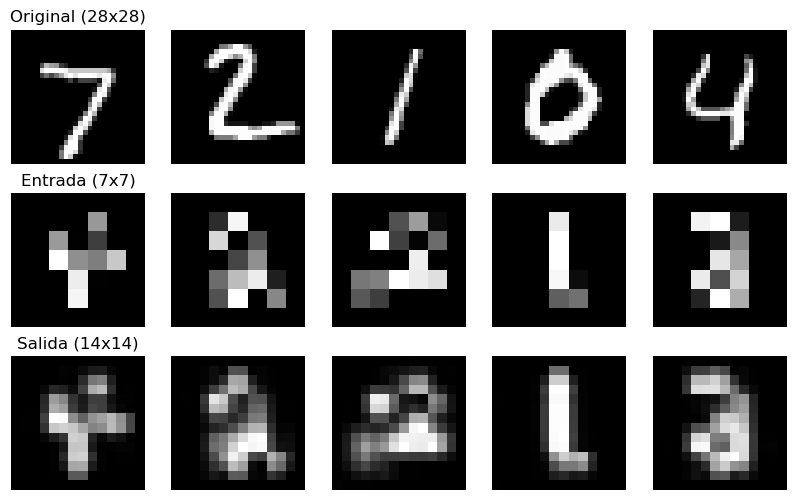

In [39]:
mnist_original = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
original_loader = DataLoader(dataset=mnist_original, batch_size=64, shuffle=False)
original_images, _ = next(iter(original_loader))

resized_images, _ = next(iter(data_loader_valid))

n = 5  # Número de imágenes a visualizar
with torch.no_grad():
    model.eval()
    resized_images = resized_images.to(device)[:n]
    reconstructions = model(resized_images).cpu()

fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(10, 6))
for i in range(n):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(original_images[i].squeeze(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Original (28x28)')

    # Imagen redimensionada
    ax = axes[1, i]
    ax.imshow(F.interpolate(resized_images.cpu(), size=(28, 28))[i].squeeze(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Entrada (7x7)')

    # Imagen reconstruida
    ax = axes[2, i]
    ax.imshow(reconstructions[i].squeeze(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Salida (14x14)')

plt.show()
